In [1]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/scratch/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2

## Read in Data

In [2]:
data_frame = pd.read_csv('./cpm_exclude.txt', sep='\t')
data_frame = data_frame[[x for x in data_frame.columns.values if not 'med' in x and not 'NEG' in x]]
data_frame.columns = [x.replace('PVHproj_LPBN', 'mCherryPOS') for x in data_frame.columns.values]

In [3]:
# fix the log transformation
unlogged_frame = data_frame[[]]

for col in data_frame.columns:
    unlogged_frame[col] = [np.power(2,x) for x in data_frame[col]]
unlogged_frame.index = data_frame.index.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
relogged_frame = np.log2(unlogged_frame + 1)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


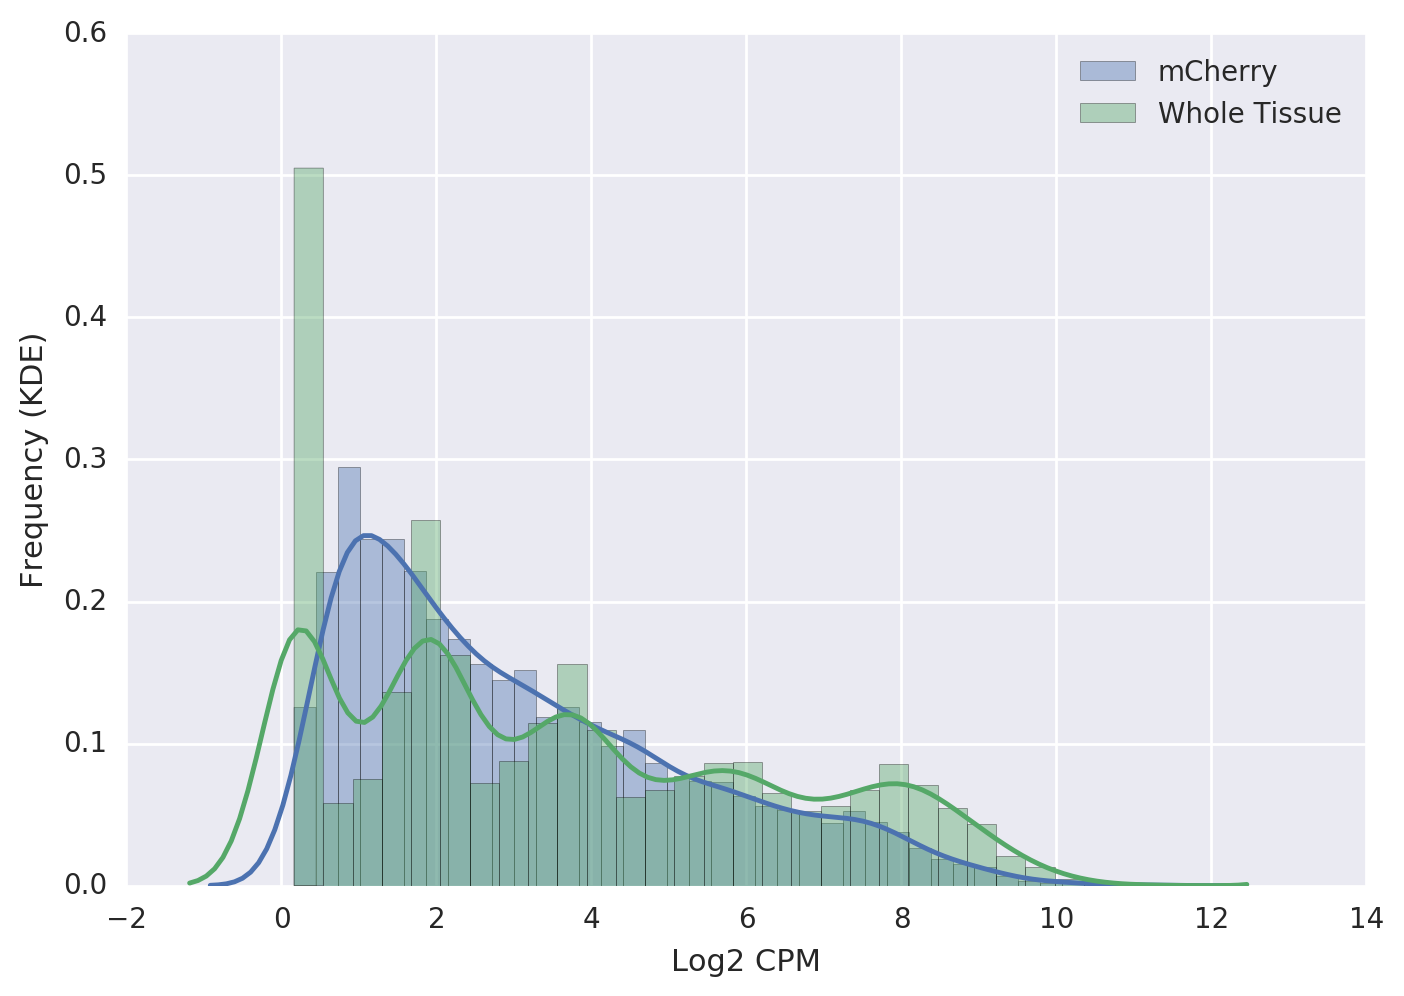

In [5]:
sns.distplot(relogged_frame[[x for x in relogged_frame.columns if 'mCherry' in x]].mean(axis=1), 
             label = 'mCherry')
sns.distplot(relogged_frame[[x for x in relogged_frame.columns if 'tis' in x]].mean(axis=1),
             label = 'Whole Tissue')
plt.xlabel('Log2 CPM')
plt.ylabel('Frequency (KDE)')
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


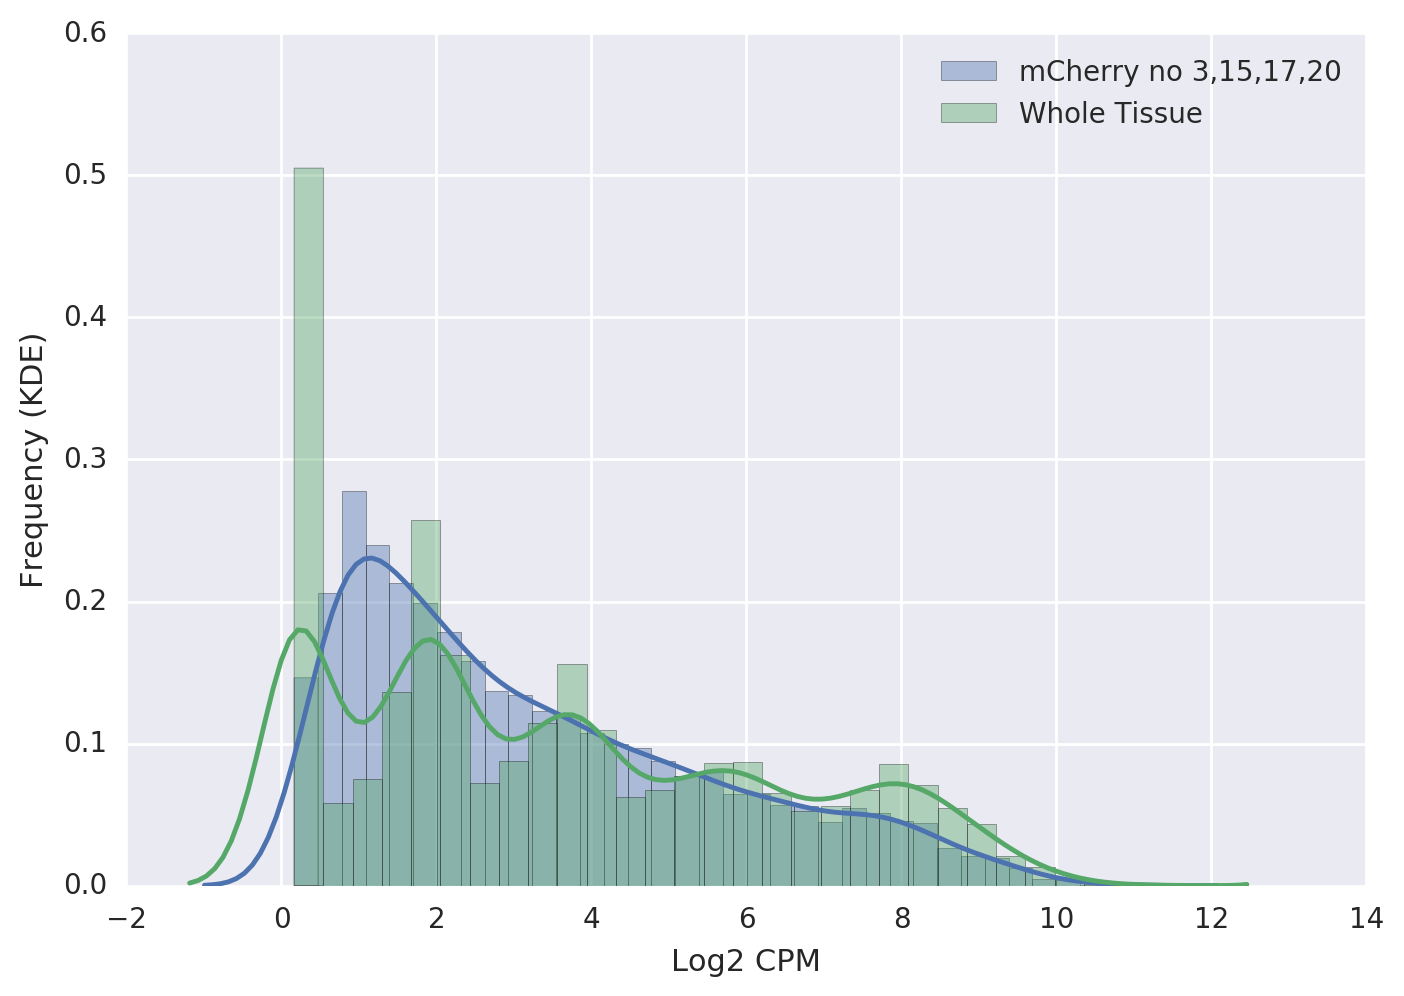

In [6]:
sns.distplot(relogged_frame[[x for x in relogged_frame.columns if 'mCherry' in x and not x.split('_')[-1] in  ['c03', 'c15', 'c17', 'c20']]].mean(axis=1), 
             label = 'mCherry no 3,15,17,20')
sns.distplot(relogged_frame[[x for x in relogged_frame.columns if 'tis' in x]].mean(axis=1),
             label = 'Whole Tissue')
plt.xlabel('Log2 CPM')
plt.ylabel('Frequency (KDE)')
plt.legend()

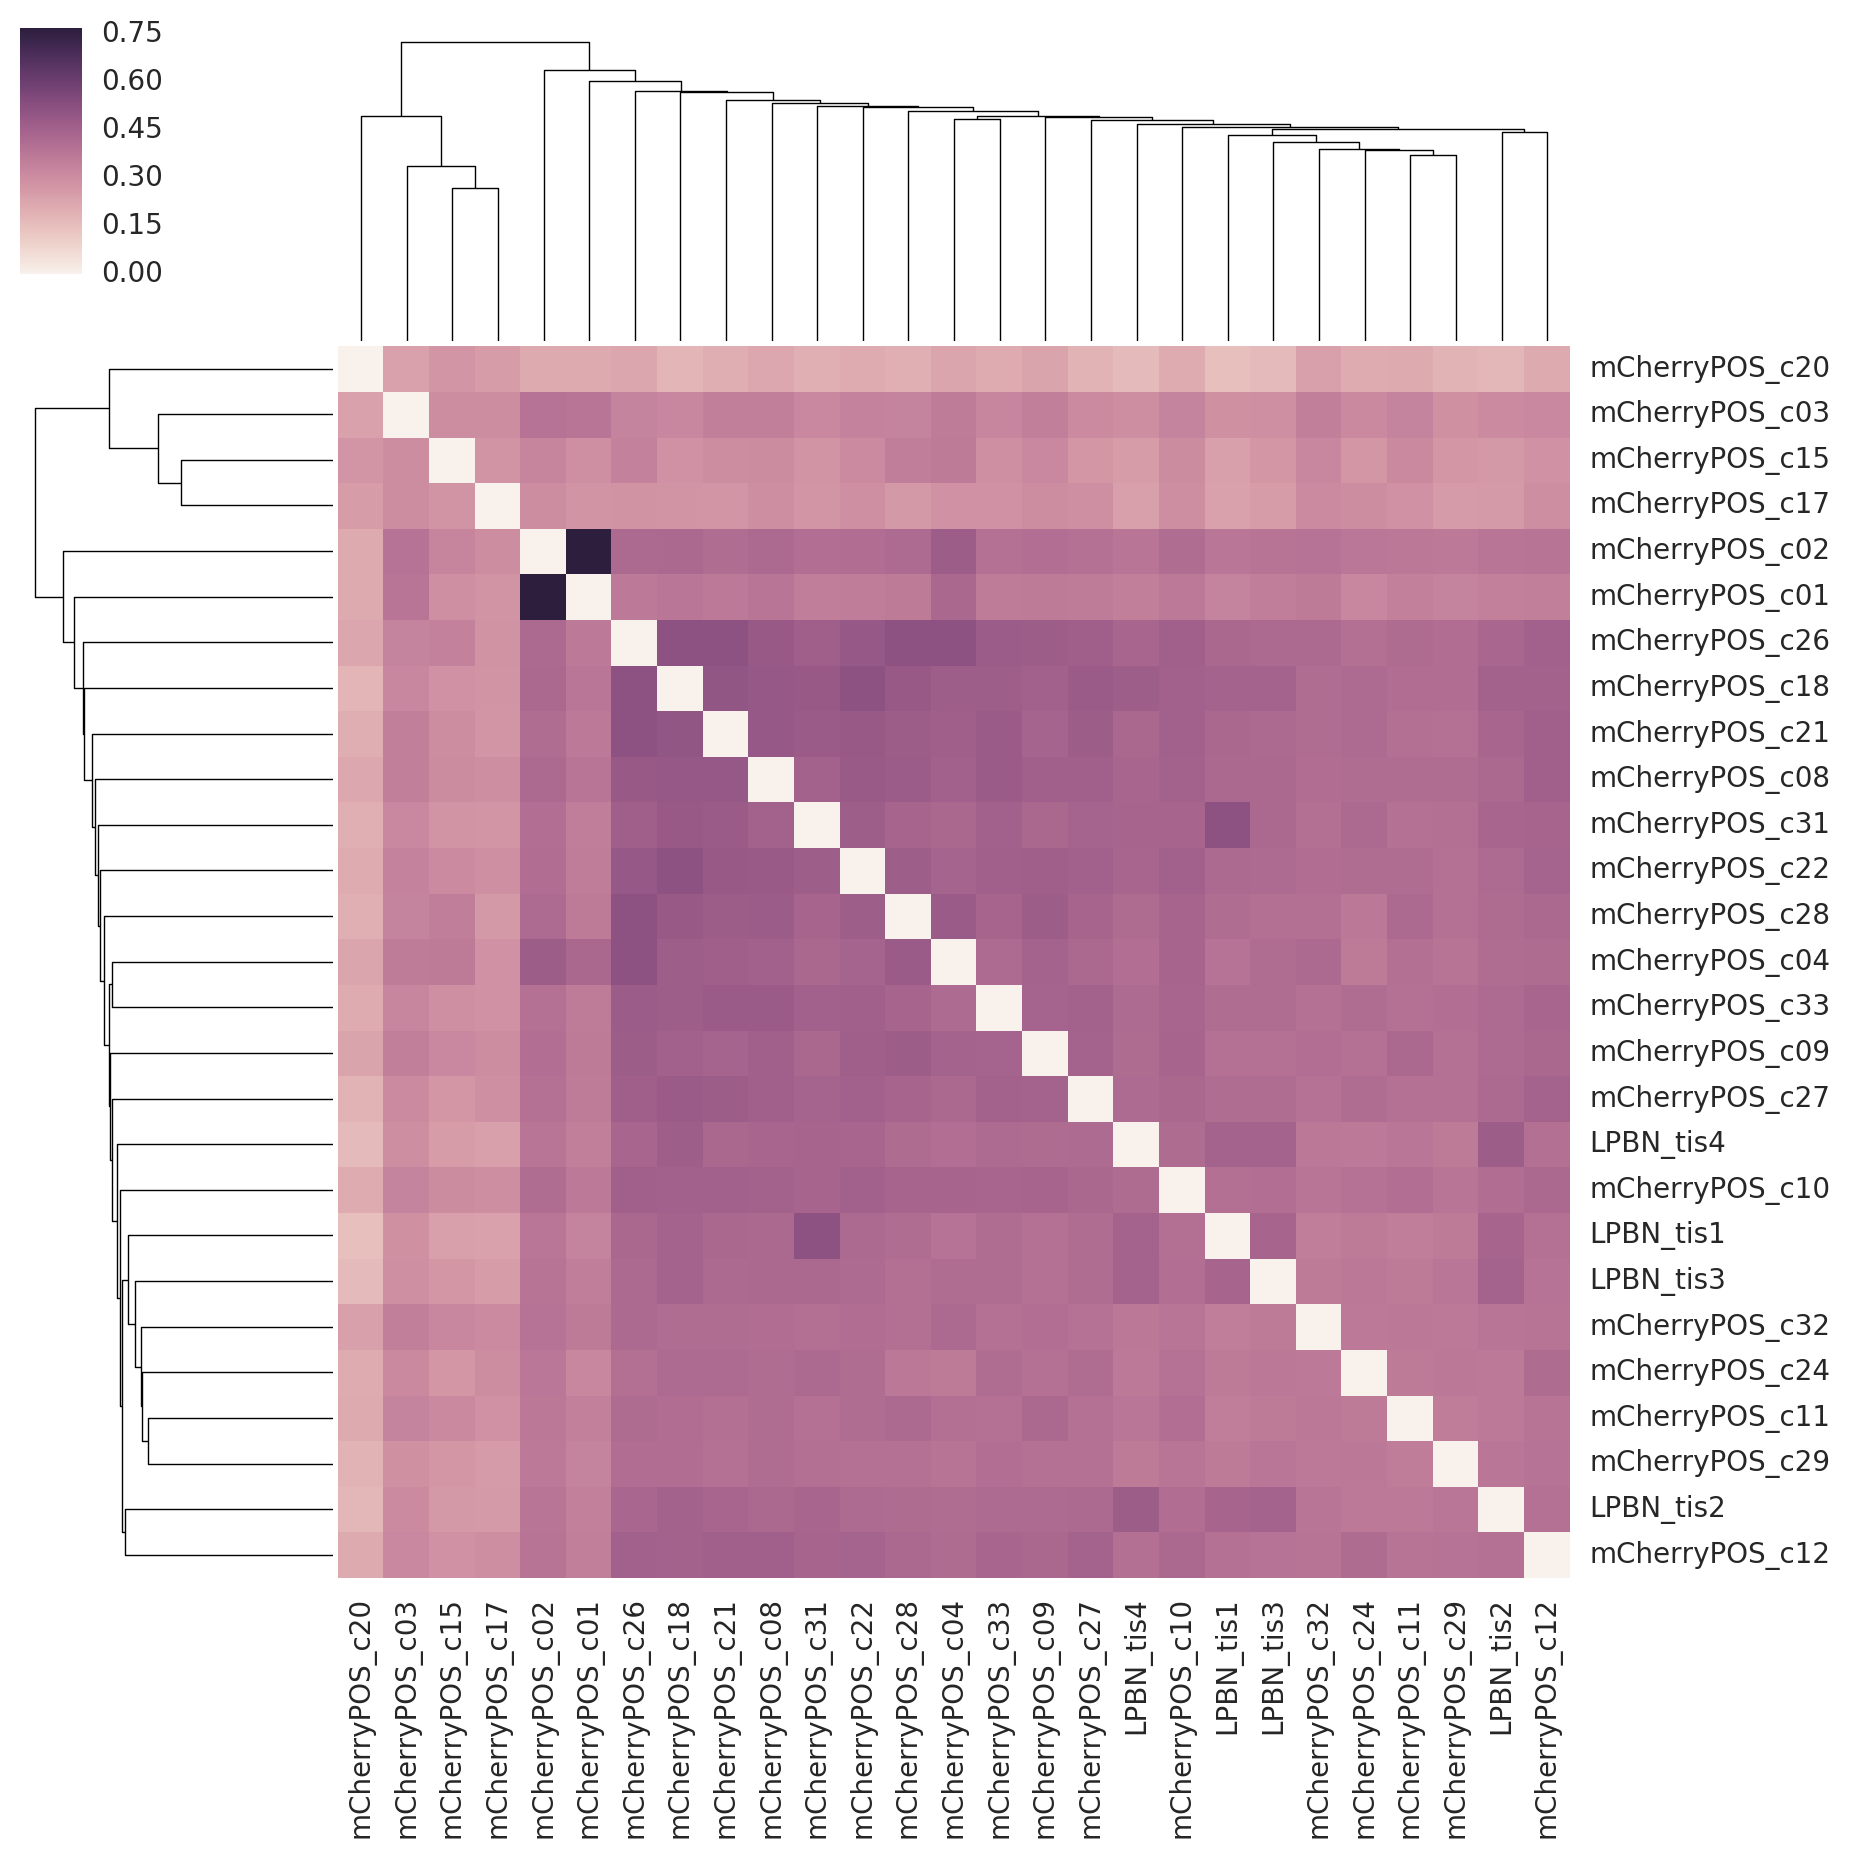

In [8]:
samples = relogged_frame.columns.values

labels = samples

spearman_matrix = np.zeros((len(samples), len(samples)))
pearson_matrix = np.zeros((len(samples), len(samples)))
# for i in range(len(samples)):
#     spearman_matrix[i][i]=1.0
#     pearson_matrix[i][i]=1.0

for i in range(len(samples) - 1):
    for j in range(i+1, len(samples)):
        values_1 = relogged_frame[samples[i]].values
        values_2 = relogged_frame[samples[j]].values
        pearson, pearson_pval = scipy.stats.pearsonr(values_1,values_2)
        spearman, spearman_pval = scipy.stats.spearmanr(values_1,values_2)
        pearson_matrix[i][j] = pearson
        pearson_matrix[j][i] = pearson
        
        spearman_matrix[i][j] = spearman
        spearman_matrix[j][i] = spearman
        
        

# sns.set_context('notebook', font_scale=0.9)
cg = sns.clustermap(pearson_matrix, xticklabels=labels, yticklabels=labels, metric='euclidean')
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

# cg = sns.clustermap(spearman_matrix, xticklabels=labels, yticklabels=labels, metric='correlation')
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()

In [58]:
relogged_frame.columns.values

array(['LPBN_tis1', 'LPBN_tis2', 'LPBN_tis3', 'LPBN_tis4',
       'mCherryPOS_c01', 'mCherryPOS_c02', 'mCherryPOS_c03',
       'mCherryPOS_c04', 'mCherryPOS_c08', 'mCherryPOS_c09',
       'mCherryPOS_c10', 'mCherryPOS_c11', 'mCherryPOS_c12',
       'mCherryPOS_c15', 'mCherryPOS_c17', 'mCherryPOS_c18',
       'mCherryPOS_c20', 'mCherryPOS_c21', 'mCherryPOS_c22',
       'mCherryPOS_c24', 'mCherryPOS_c26', 'mCherryPOS_c27',
       'mCherryPOS_c28', 'mCherryPOS_c29', 'mCherryPOS_c31',
       'mCherryPOS_c32', 'mCherryPOS_c33'], dtype=object)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


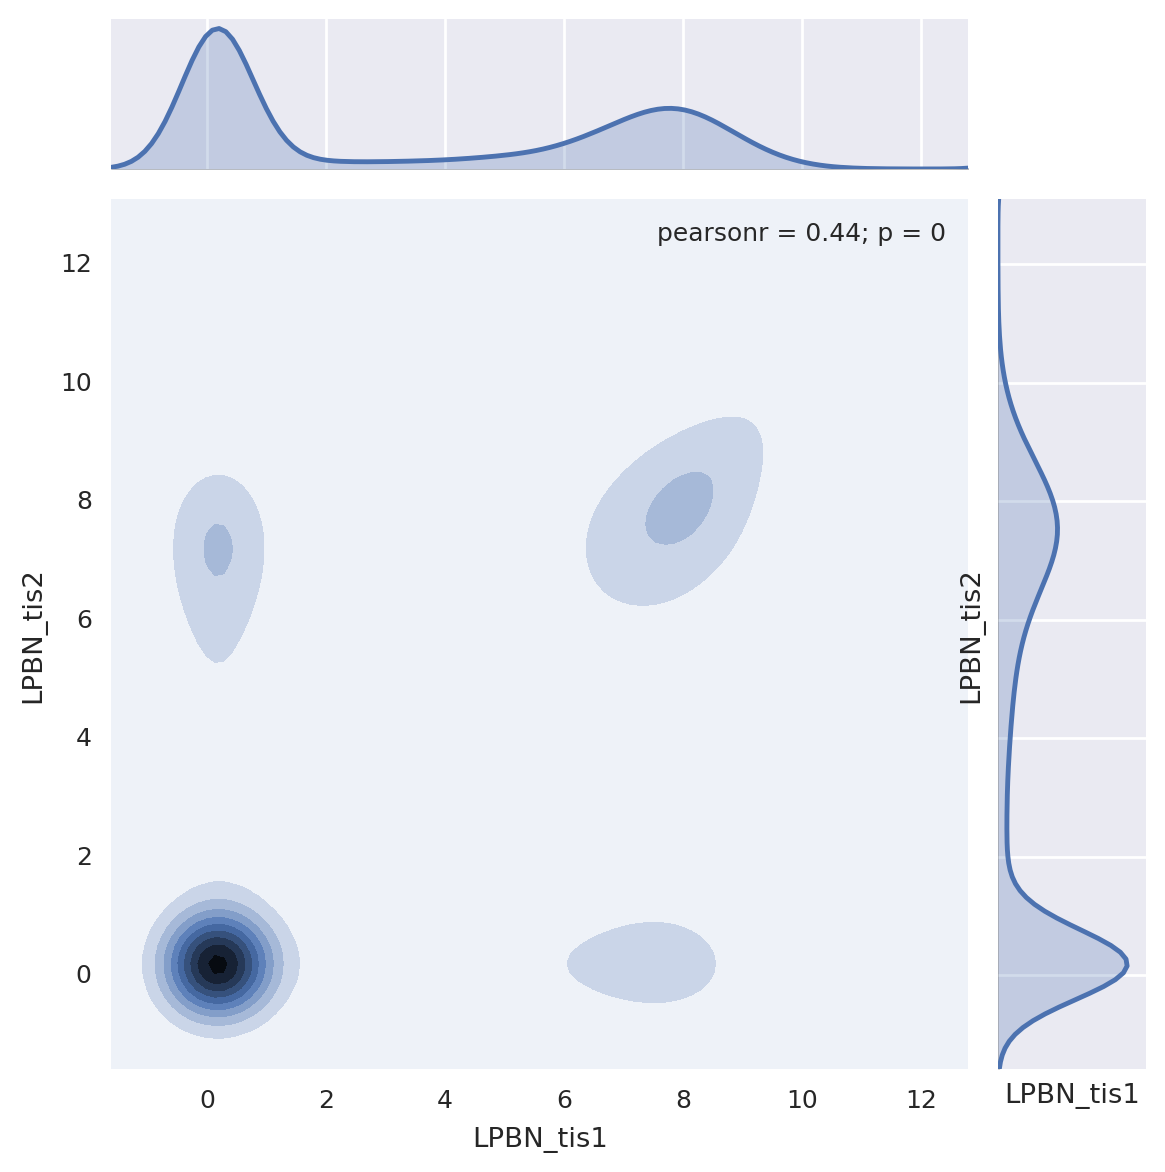

In [62]:
sns.jointplot(relogged_frame.ix[:,0], relogged_frame.ix[:,1], kind='kde')
plt.xlabel(relogged_frame.columns[0])
plt.ylabel(relogged_frame.columns[1])

### Scatter Plots

In [ ]:
sns.pairplot(relogged_frame[[x for x in relogged_frame.columns.values if 'mCherry' in x]])

### Variance Filtering

In [155]:
filtered_frame = relogged_frame[[x for x in relogged_frame.columns if not x.split('_')[-1] in  ['c03', 'c15', 'c17', 'c20']]]

mcherry_frame = filtered_frame[[x for x in filtered_frame.columns if 'mCherry' in x]]

tissue_frame = filtered_frame[[x for x in filtered_frame.columns if 'tis' in x]]

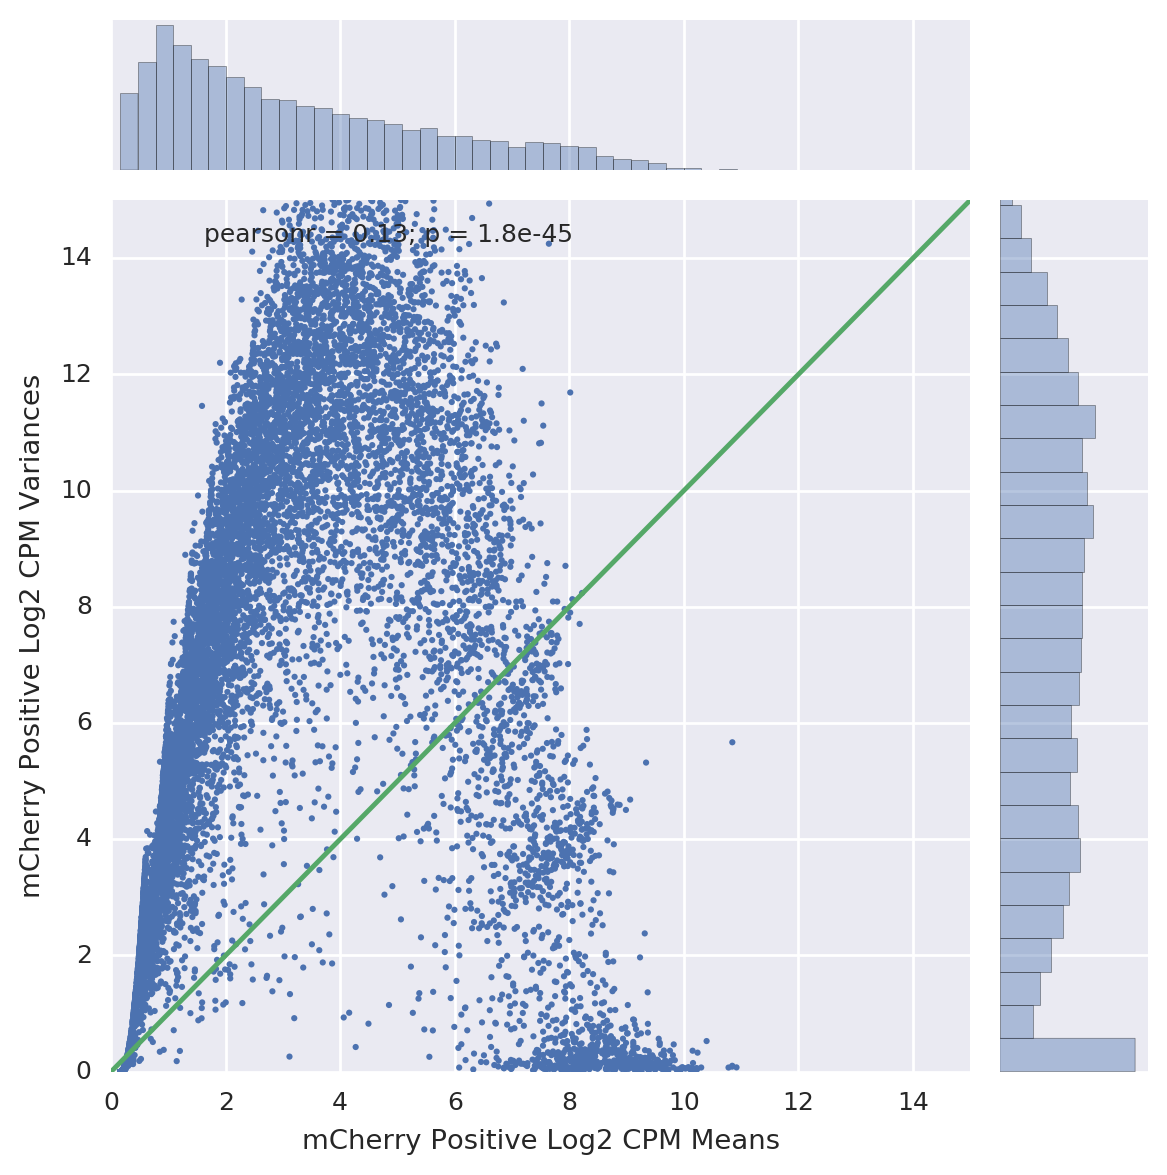

In [142]:
variances = mcherry_frame.var(axis=1)
means = mcherry_frame.mean(axis=1)
jp = sns.jointplot(means, variances,
            marker = '.', 
           edgecolor='None')
jp.ax_joint.set_xlim(0,15)
jp.ax_joint.set_ylim(0,15)
jp.ax_joint.plot([0,15], [0,15])
jp.ax_joint.set_xlabel('mCherry Positive Log2 CPM Means')
jp.ax_joint.set_ylabel('mCherry Positive Log2 CPM Variances')

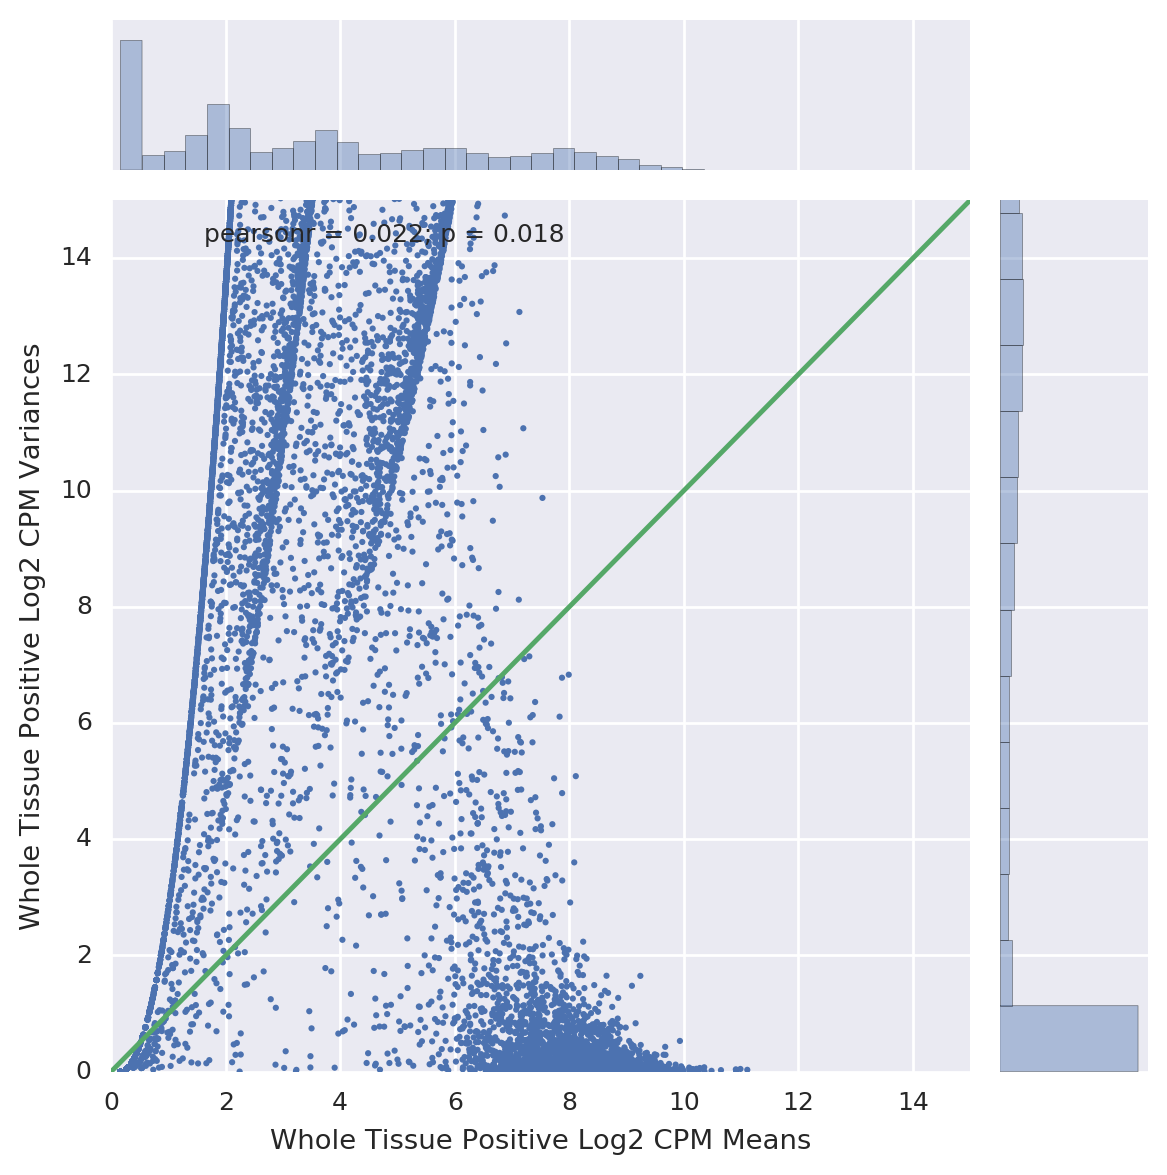

In [145]:
variances = tissue_frame.var(axis=1)
means = tissue_frame.mean(axis=1)
jp = sns.jointplot(means, variances,
            marker = '.', 
           edgecolor='None')
jp.ax_joint.set_xlim(0,15)
jp.ax_joint.set_ylim(0,15)
jp.ax_joint.plot([0,15], [0,15])
jp.ax_joint.set_xlabel('Whole Tissue Positive Log2 CPM Means')
jp.ax_joint.set_ylabel('Whole Tissue Positive Log2 CPM Variances')

In [153]:
variances = mcherry_frame.var(axis=1)

means = mcherry_frame.mean(axis=1)

filtered_mcherry_frame = mcherry_frame[means > variances]

In [156]:
variances = tissue_frame.var(axis=1)

means = tissue_frame.mean(axis=1)

filtered_tissue_frame = tissue_frame[means > variances]

In [157]:
filtered_tissue_frame.shape

(4608, 4)

In [158]:
filtered_mcherry_frame.shape

(1722, 19)

In [161]:
from matplotlib_venn import venn2

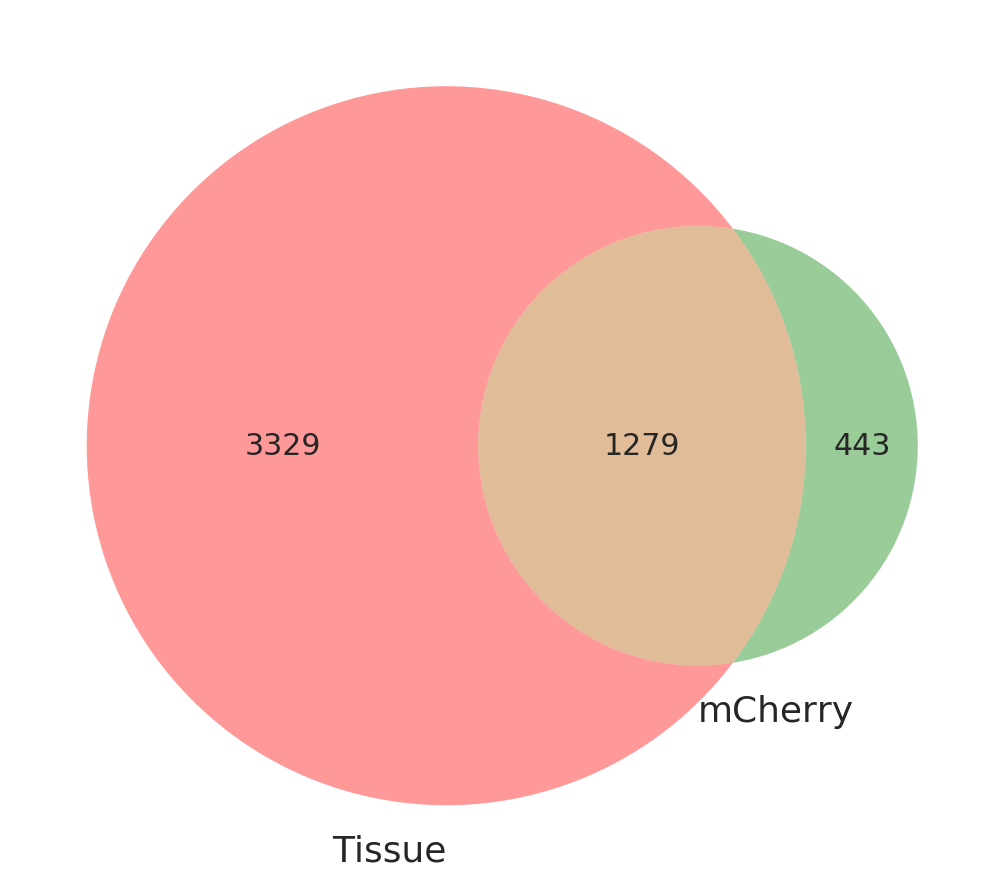

In [163]:
venn2([set(filtered_tissue_frame.index.values), set(filtered_mcherry_frame.index.values)],
       set_labels = ['Tissue', 'mCherry'])

In [164]:
intersecting_genes = sorted(set(filtered_mcherry_frame.index.values).intersection(filtered_tissue_frame.index.values))

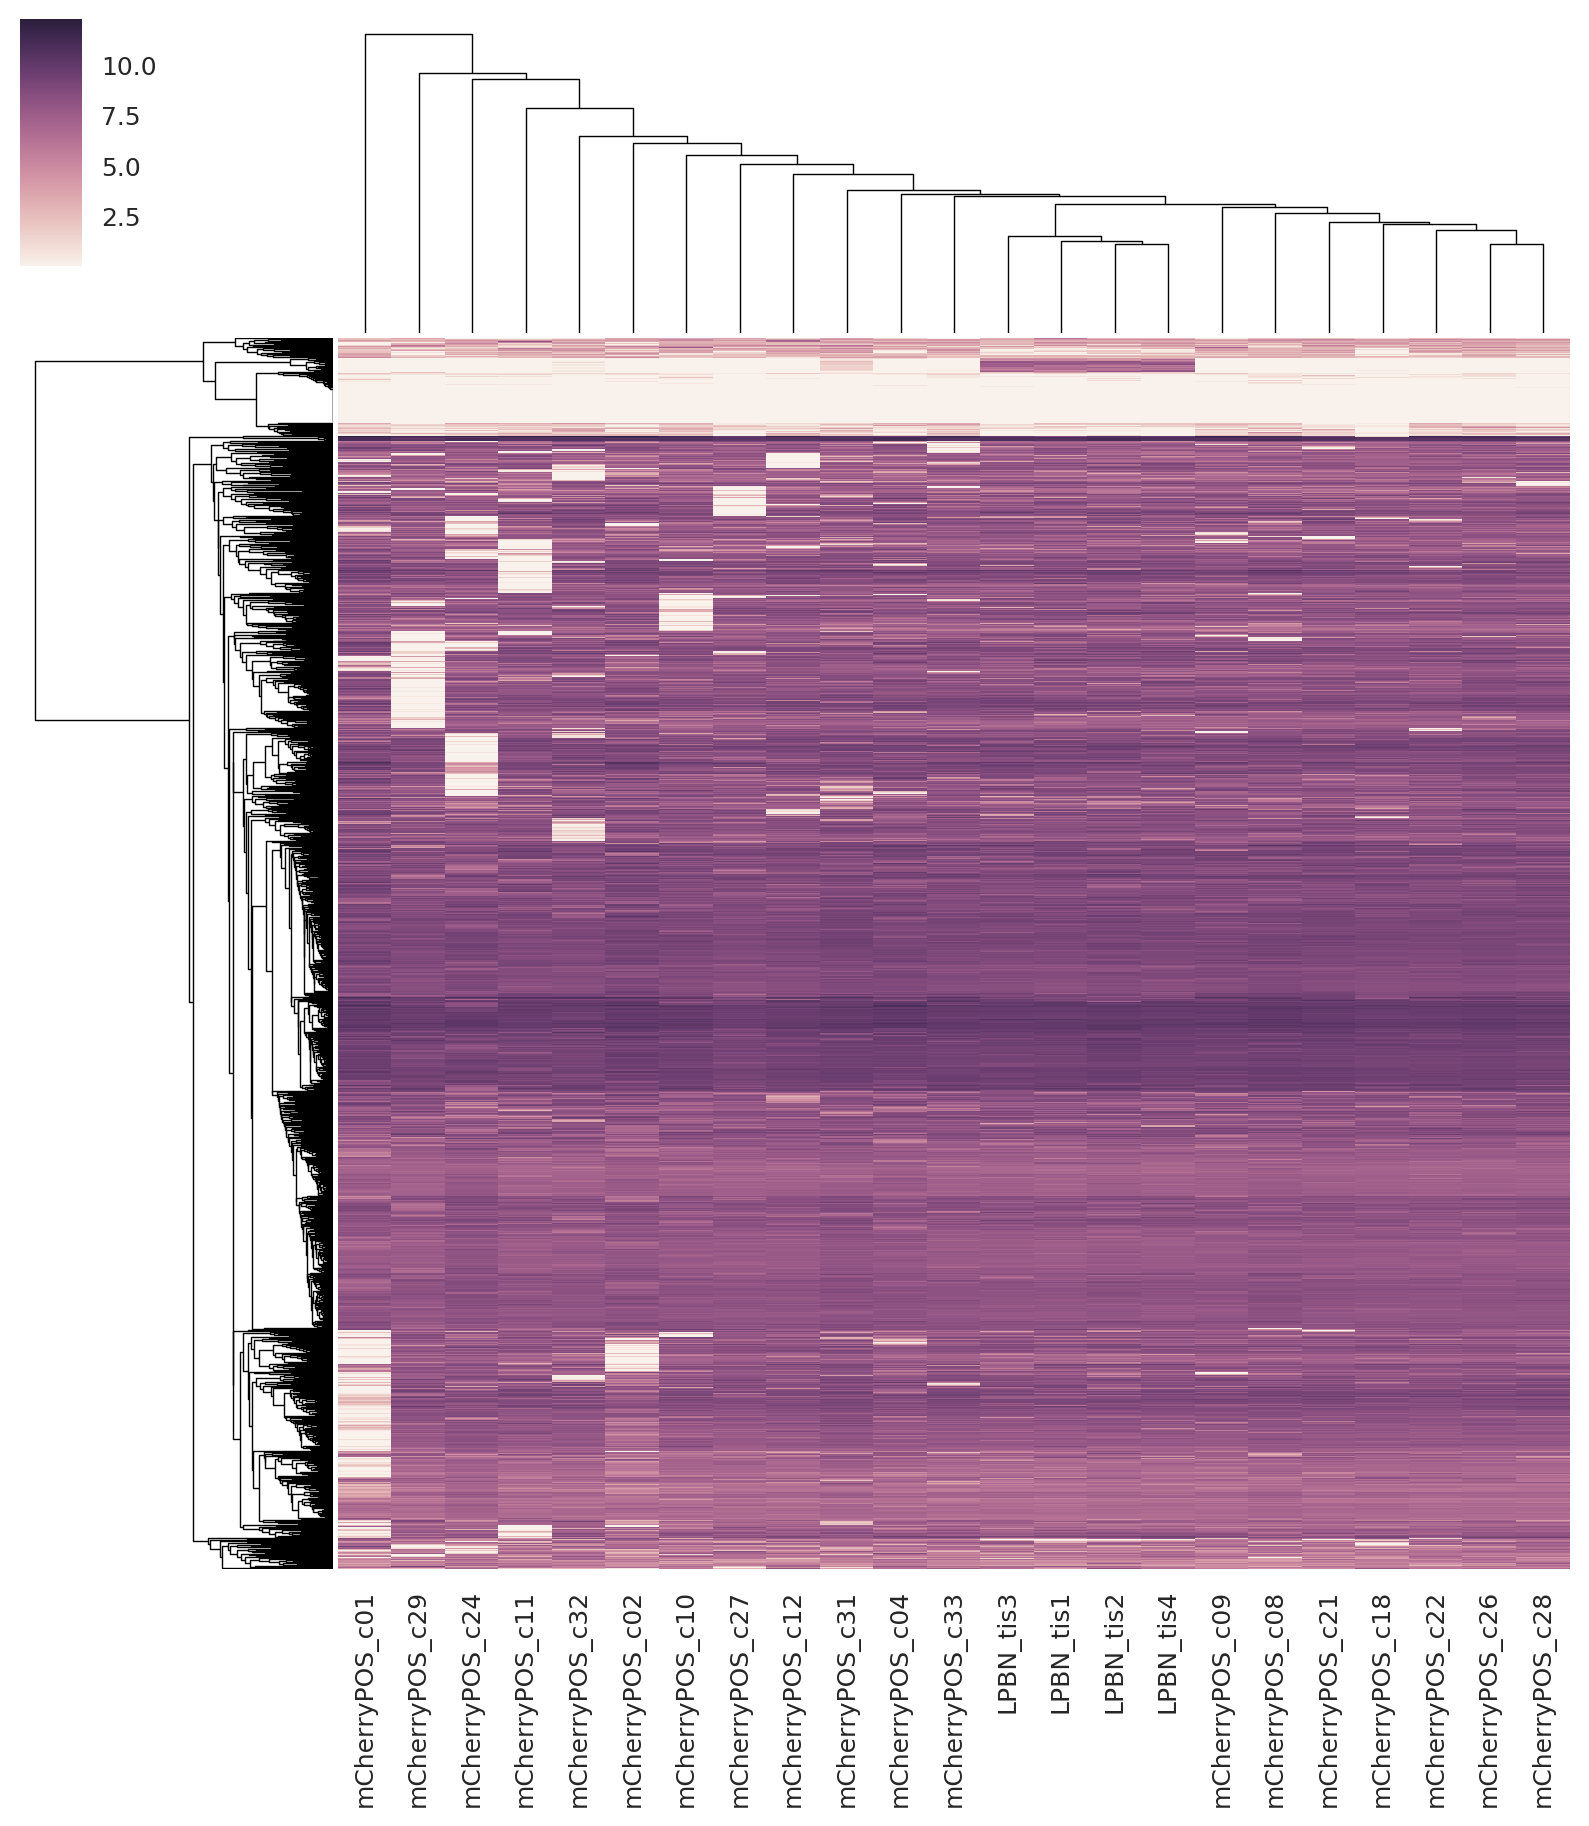

In [166]:
sns.clustermap(filtered_frame[filtered_frame.index.isin(intersecting_genes)],
              yticklabels=False)

In [168]:
intersecting_frame = filtered_frame[filtered_frame.index.isin(intersecting_genes)]

In [181]:
outfile = open('significant_genes.tsv', 'w')
outfile.write('\t'.join(['gene', 'KS 2 sample pvalue', '\n']))
for gene in intersecting_genes:
    tissue_values = filtered_tissue_frame.ix[gene,:].values
    mcherry_values = filtered_mcherry_frame.ix[gene,:].values
    stat, pval = scipy.stats.ks_2samp(tissue_values, mcherry_values)
    if pval < 0.05:
        print(gene, pval)
        outfile.write(gene + '\t' + str(pval) + '\n')
outfile.close()



uc007bac.2|Hspe1 0.0411376796739
uc007blr.2|Aamp 0.0137801206377
uc007boq.1|Ptprn 0.0475652247981
uc007bvp.1|Ptma 0.00334462744452
uc007cwb.2|Dennd1b 0.0137801206377
uc007dag.2|Rnasel 0.0475652247981
uc007dky.1|Mgst3 0.0261746692369
uc007dnb.2|Sdhc 0.0261746692369
uc007dpy.1|Pea15a 0.0223885410536
uc007dqc.1|Atp1a2 0.00334462744452
uc007dwf.1|Gm5069 0.0475652247981
uc007edj.2|Rcor3 0.00154195377485
uc007epk.2|C920009B18Rik 0.000680110005729
uc007fmw.1|Ank3 0.0261746692369
uc007ftq.1|Chchd10 0.0137801206377
uc007gvq.1|Ndufa12 0.0475652247981
uc007has.1|Atxn7l3b 0.0261746692369
uc007hmq.1|Nabp2 0.0137801206377
uc007hvb.1|Uqcr10 0.000680110005729
uc007ica.1|Ppp3r1 0.0137801206377
uc007ijk.1|Hba-a2 0.000680110005729
uc007jcq.1|Rnf187 0.0411376796739
uc007ket.2|Ywhae 0.0261746692369
uc007kiw.2|Aldoc 0.00154195377485
uc007lbf.2|Atp5g1 0.00154195377485
uc007med.2|Sox9 0.00154195377485
uc007mfm.1|Ttyh2 0.000680110005729
uc007mtj.1|Arhgdia 0.0137801206377
uc007ogz.1|Tmed10 0.0261746692369
uc007

In [182]:
for gene in intersecting_genes:
    tissue_values = filtered_tissue_frame.ix[gene,:].values
    mcherry_values = filtered_mcherry_frame.ix[gene,:].values
    stat, pval = scipy.stats.ks_2samp(tissue_values, mcherry_values)
    if pval < 0.05:
        print(gene.split('|')[-1])




Hspe1
Aamp
Ptprn
Ptma
Dennd1b
Rnasel
Mgst3
Sdhc
Pea15a
Atp1a2
Gm5069
Rcor3
C920009B18Rik
Ank3
Chchd10
Ndufa12
Atxn7l3b
Nabp2
Uqcr10
Ppp3r1
Hba-a2
Rnf187
Ywhae
Aldoc
Atp5g1
Sox9
Ttyh2
Arhgdia
Tmed10
Hsp90aa1
Acot13
Cxcl14
Ubqln1
Tkt
Gm1821
Cmtm5
Psme1
Rpl30
Ncald
Vps28
Cyhr1
Syngr1
Mlc1
Slc48a1
Pfkm
Atp5g2
Pam16
Ube2v2
A630089N07Rik
Tceb2
Ndufb10
Mapk8ip3
Pacsin1
Slc39a7
Ptprs
Clpp
Celf4
Ndufa2
Trim36
Mbp
Malat1
Eef1g
Usmg5
Sfr1
Prdx3
Npdc1
Ppp2r4
BC005624
Dnm1
Ndufa8
Prn
Tmx4
Cst3
Nfs1
Mroh8
Snhg11
Ndufc1
Tpm3
Wdr77
Rab2a
Kif24
Dctn3
Plpp3
Atpif1
Clic4
C1qb
C1qa
Hp1bp3
Pink1
Camta1
Gm1673
Qdpr
Gak
AK138792
Vps29
Actb
Atp5j2
Gng11
1110001J03Rik
Cycs
Dctn1
Ldhb
Tyrobp
Ftl1
Ldha
Ndufc2
Olfr613
Ypel3
Cend1
Lamp1
Cpe
Atp6v1b2
Ndufa13
Abhd8
Junb
Fa2h
Atp5l
Scn2b
Ncam1
Acsbg1
Pkm
9530091C08Rik
Scg3
Eef1a1
Wdr6
Clasp2
Clasp2
Deb1
Syp
Cxx1c
Idh3g
Cox7b
Wbp5
AK140265
AK163440
X57780
Itm2c
Tmbim6
Got1
Ccl27a
Meg3
Tomm6os
Pol
AI593442
EU233994
AK153773


### PCA

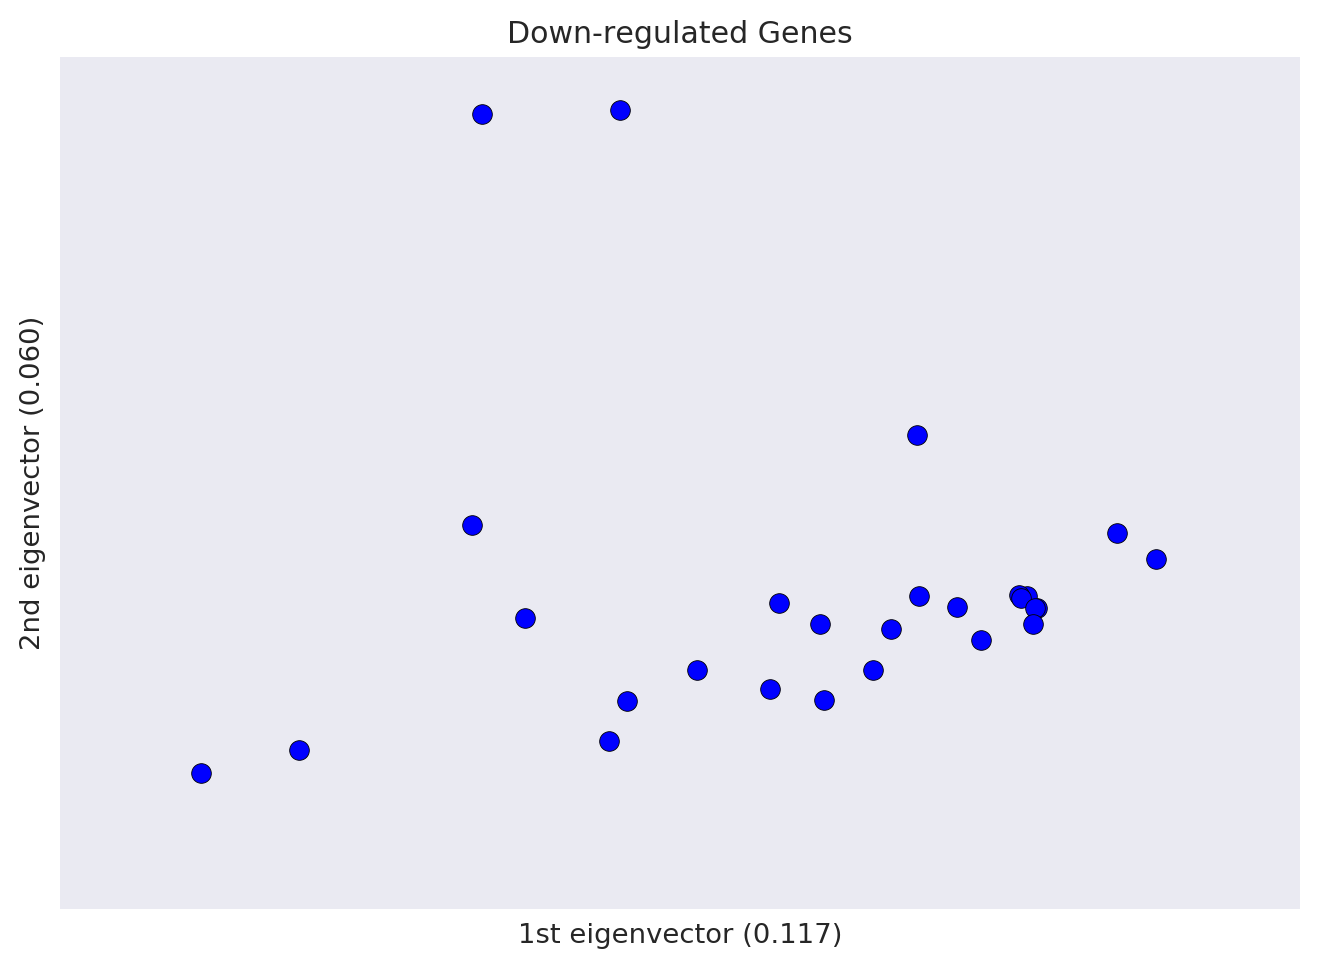

In [50]:
### for up-regulated genes
from matplotlib import patches as mpatches

# colorDict = dict(zip(sorted(set(filtered_summary_frame['simpleTreatment'].values)), 
#                  sns.color_palette("Set2") + sns.color_palette("colorblind")))

### down_regulated genes
features = relogged_frame
# colors = [colorDict[x] for x in features.columns.values]

down_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = down_model.fit_transform(features.T)
explained_variance_ratios = down_model.explained_variance_ratio_
xvals = reduced_features[:, 0]
yvals = reduced_features[:, 1]
plt.scatter(xvals,
            yvals, 
            s=50)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Down-regulated Genes')